---
aliases:
- /2023/07/14/Neural-likelihood-estimation
author: Yves Barmaz
badges: true
branch: master
categories:
- simulation-based inference
- machine learning
- tensorflow-probability
date: '2023-07-14'
description: A discussion of simulation-based inference fueled by machine learning algorithms, with an example of neural likelihood estimation in TensorFlow Probability.
output-file: 2023-07-14-Neural-likelihood-estimation.html
title: "Neural likelihood estimation and simulation-based inference"
toc: false
echo: true
comments:
  utterances:
    repo: ybarmaz/blog

---

## Simulation and inference
The problem of estimating quantities that are not directly observable is very common in science, engineering and business applications, and evaluating the uncertainty of these estimates is often as important as the accuracy of the "best guess". Hypothesis testing and risk management would not be possible without quantifying uncertainty, which has motivated the development of statistics as the scientific discipline that addresses these questions.

The usual workflow of a statistical analysis involves the definition of a joint probability distribution of measurements and (hidden) quantities of interest, followed by the application of some inference algorithm to retrieve those quantities from the observed data following the [likelihood principle](https://en.wikipedia.org/wiki/Likelihood_principle), which states that all the evidence in a sample relevant to model parameters is contained in the likelihood function.

However, scientific models are normally built in the opposite direction: given some model parameters, they prescribe a way to simulate observations, often with intermediate unobserved states. Statistical inference algorithms then effectively aim at solving the inverse problem: given the observations, they prescribe a way to retrieve the model parameters, and hidden states when applicable.

Sometimes the scientific models are expressed as a probability distribution, which immediately defines a likelihood function, and the statistical analysis can focus on inference. In most cases, though, the joint distribution is only implicit and the statistical analysis must start with the derivation of a likelihood function at best, or at least of an approximation thereof.

A common approach is to simulate observations from a model and build an empirical distribution of measurements to design a statistical test of the validity of the model. This approach is at the heart of the [scientific method](https://en.wikipedia.org/wiki/Scientific_method) but is more cumbersome when we want to estimate the value of model parameters.

## Simulation-based inference
In the previous [post](https://ybarmaz.github.io/blog/posts/2023-06-24-Velociraptors-and-rabbits.html) of this blog, we discussed such a problem where we were interested in inferring the parameters of a population model with no known likelihood function. We relied on SMC-ABC, an example of [approximate Bayesian computation](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation), where a surrogate likelihood function is used in a Bayesian inference algorithm.

This type of algorithm that does not require a likelihood function is often referred to as [simulation-based inference](https://simulation-based-inference.org/), a very active research area in computational statistics. This activity is partly fueled by advances in machine learning, where neural networks have been built to approximate all kinds of mathematical functions. In particular, normalizing flows have proven useful in approximating probability distributions, especially the [masked autoregressive flow for density estimation](https://arxiv.org/abs/1705.07057).

The benefit of these normalizing flows for simulation-based inference becomes apparent if we sample model parameters $\theta$ from a certain proposal distribution $\pi(\theta)$, and use the simulator model to generate synthetic data $X$. We can then use a flow model to learn an estimate $\tilde p(\theta, X)$ of the joint distribution, or even $\tilde p(X \vert \theta)$ of the conditional distribution of the observations given the parameters.

For an example, we can go back to the Lotka-Volterra competition model discussed in the previous [post](https://ybarmaz.github.io/blog/posts/2023-06-24-Velociraptors-and-rabbits.html).

In [1]:
#| echo: false
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-doc")


2023-07-12 20:06:31.380753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


https://github.com/smsharma/sbi-lecture-mit

https://github.com/smsharma/jax-conditional-flows/tree/main



In [2]:
# Definition of true parameters
a = 1.
b = 0.1
c = 1.5
d = 0.075

# initial population of rabbits and velociraptors
X0 = [10., 5.]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

In [3]:
# ode_int = tfp.math.ode.BDF()
ode_int = tfp.math.ode.DormandPrince()

# simulator function
@tf.function(experimental_compile=True)
def competition_model(x0, y0, alpha, beta, gamma, delta):
  # Lotka - Volterra equation
  def ode_fn(t, X):
    """ Return the growth rate of velociraptor and rabbit populations. """
    dX_dt = alpha*X[0] - beta*X[0]*X[1]
    dY_dt = -gamma*X[1] + delta*X[0]*X[1]
    return [dX_dt, dY_dt]

  return ode_int.solve(
      ode_fn,
      initial_time=0.,
      initial_state=[x0, y0],
      solution_times=t)

# Generating noisy data to be used as observed data.
def add_noise(x0, y0, a, b, c, d):
  noise = np.random.normal(size=(size, 2))
  simulated = tf.stack(competition_model(
      x0, y0, a, b, c, d).states).numpy().T
  simulated += noise
  indexes = np.sort(np.random.randint(low=0, high=size, size=size))    
  return simulated[indexes]

observed = add_noise(X0[0], X0[1], a, b, c, d)

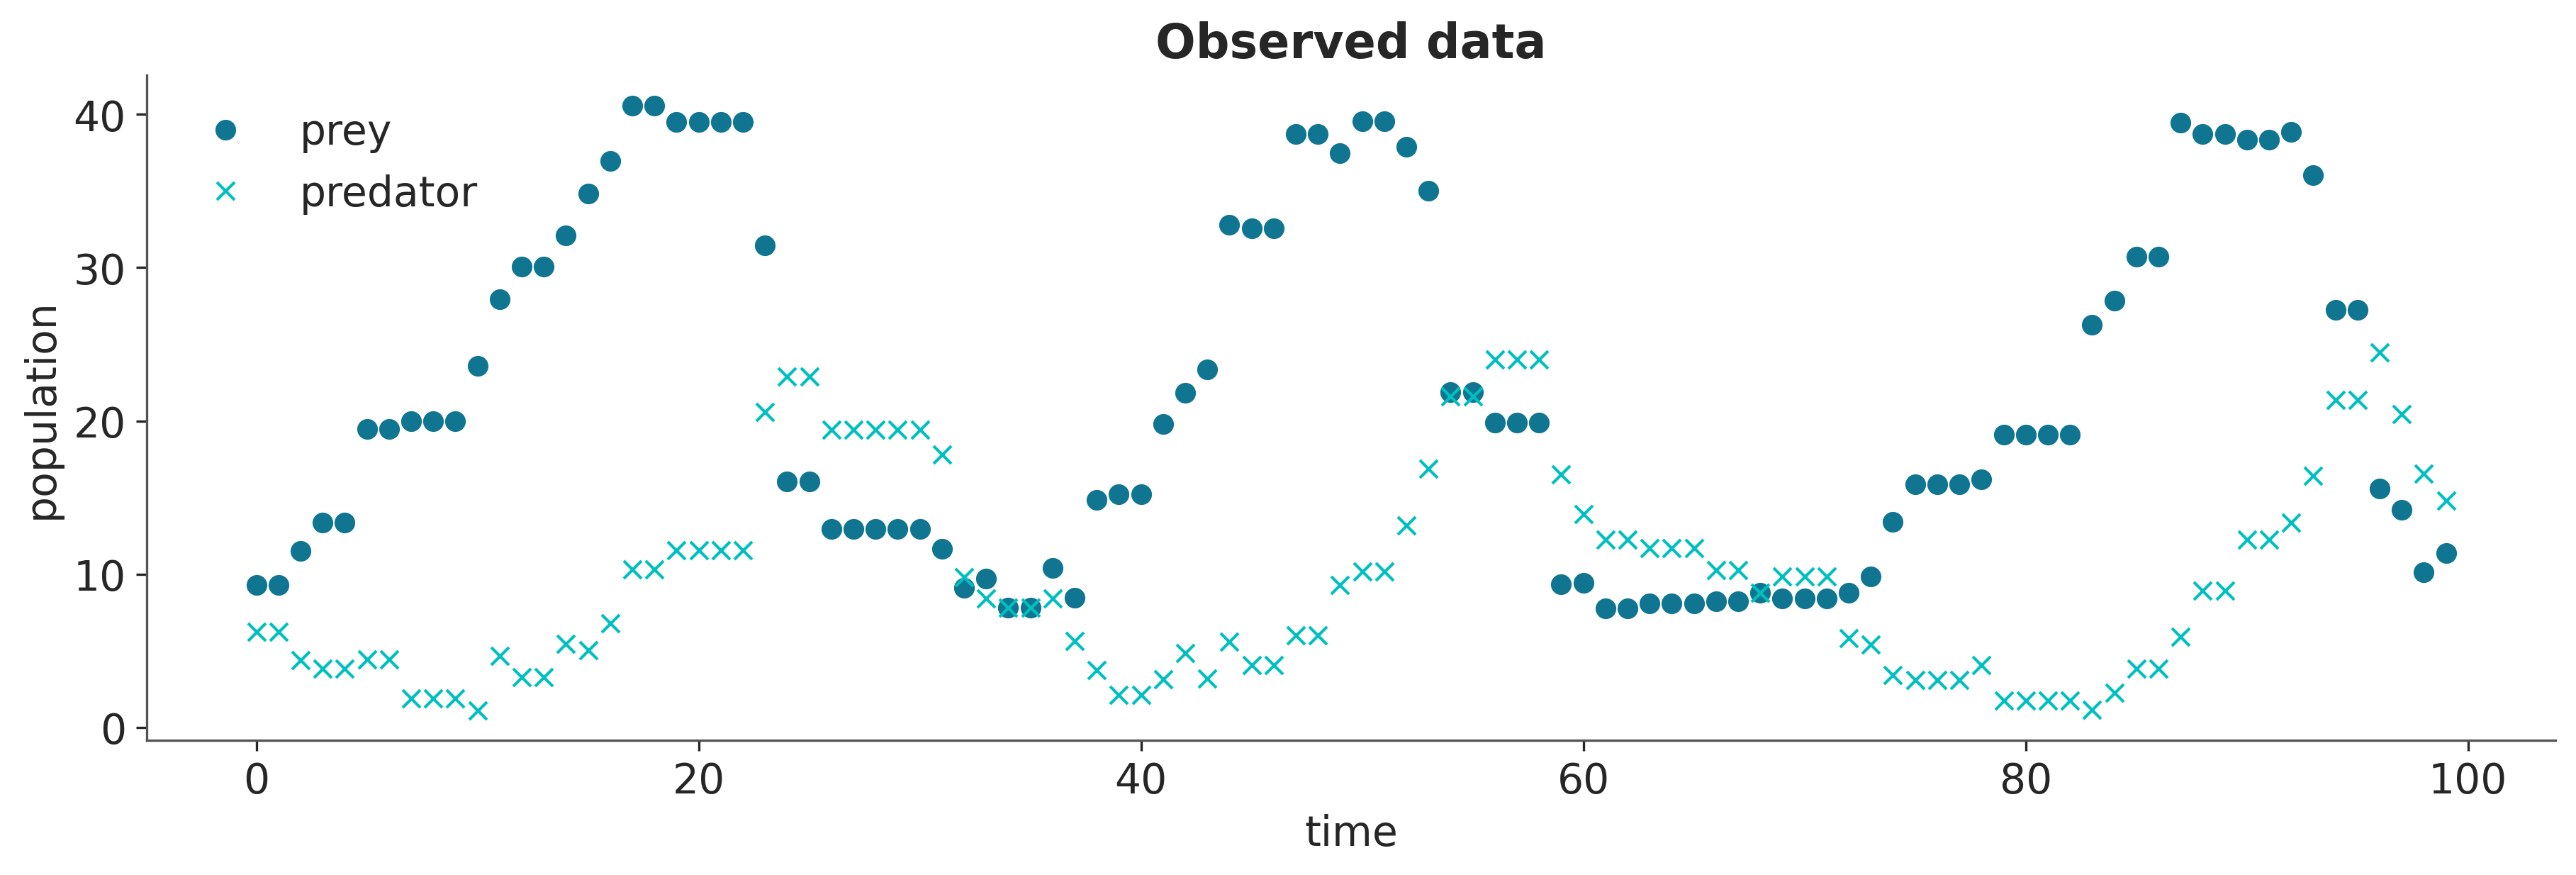

In [4]:
#| echo: false

# plotting observed data.
def plot_ode(state0, state1):
  _, ax = plt.subplots(figsize=(12,4))
  ax.plot(state0, 'o', label='prey')
  ax.plot(state1, 'x', label='predator')
  ax.set_xlabel('time')
  ax.set_ylabel('population')
  ax.set_title('Observed data')
  return ax

ax = plot_ode(observed[:,0], observed[:,1])
ax.legend();

We can use the prior distribution as a proposal distribution to sample model parameters, and generate synthetic observations with the `competition_model` simulator.

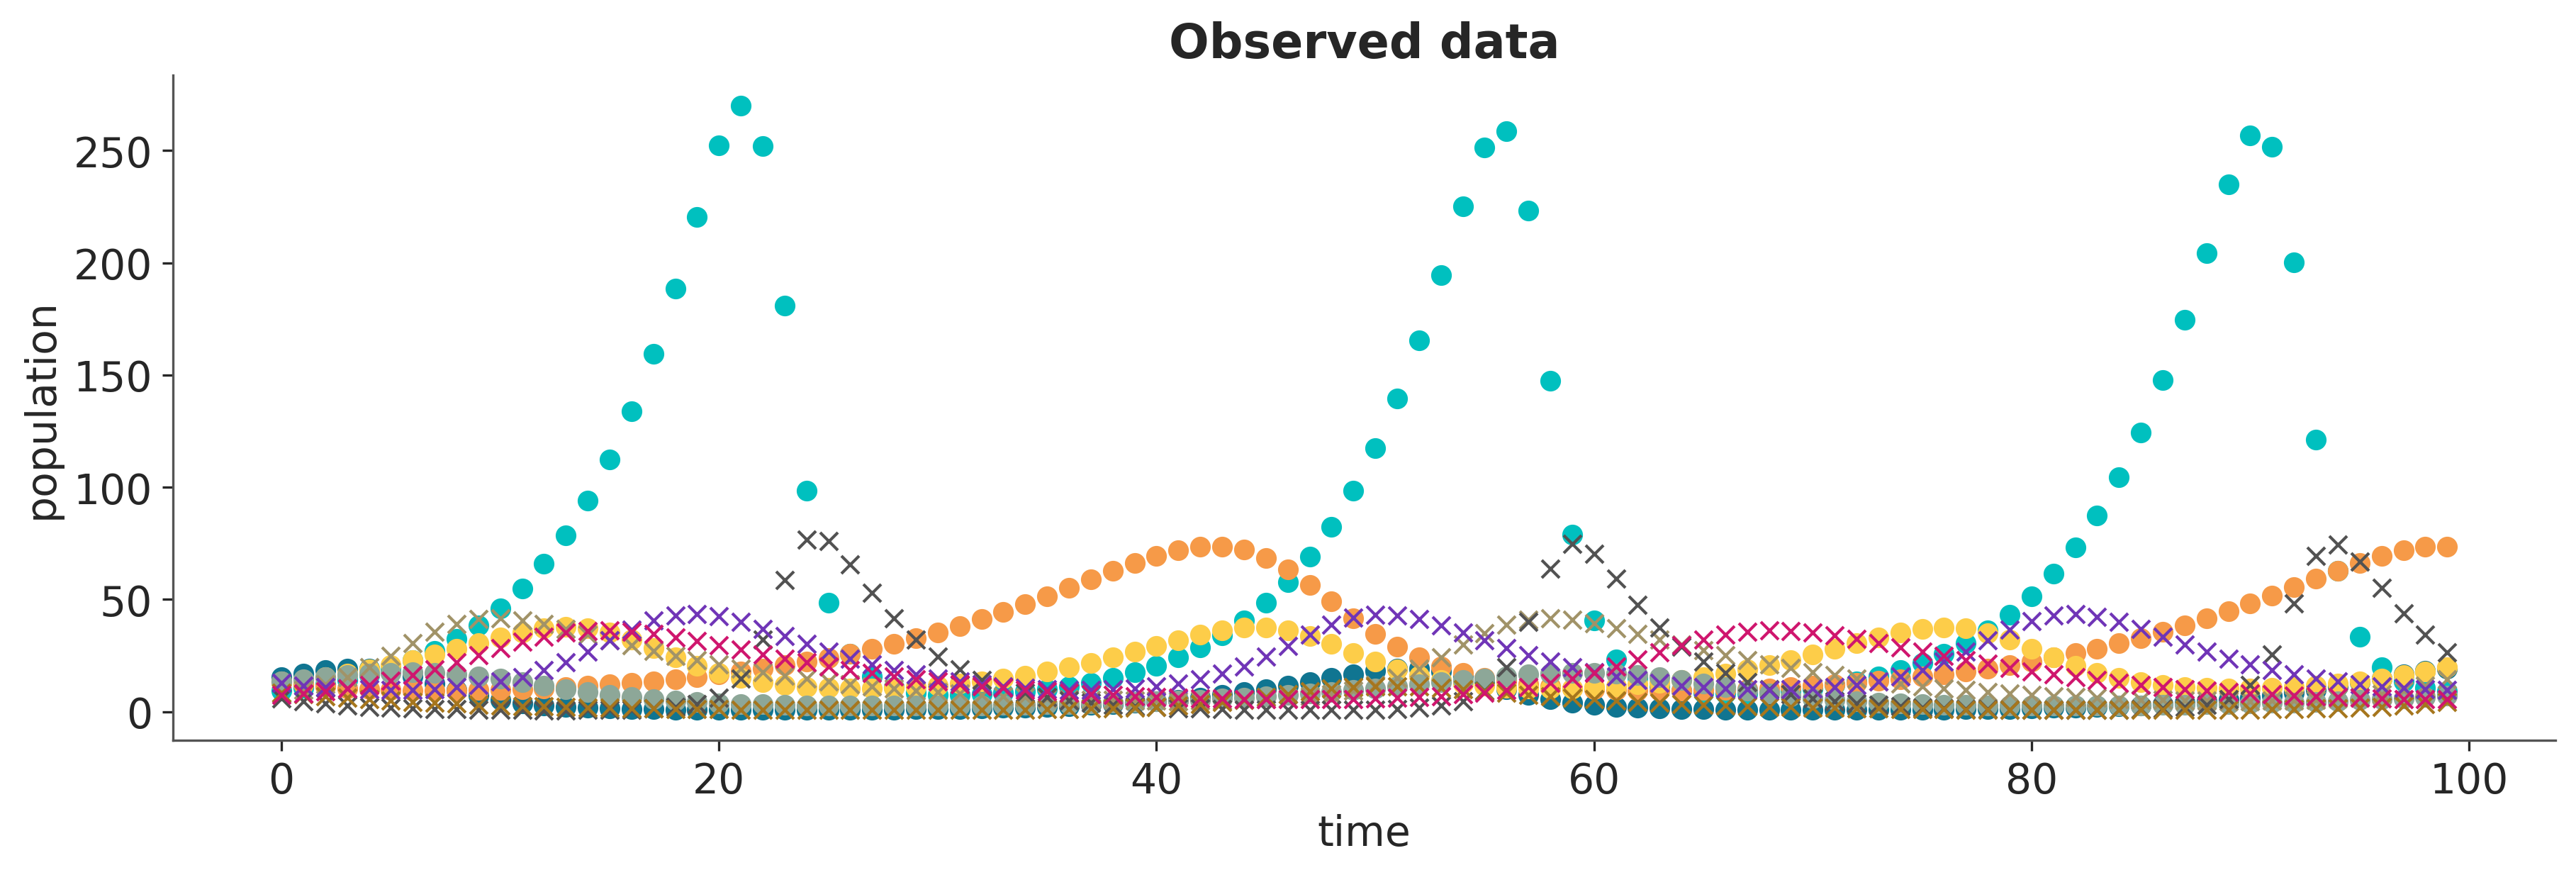

In [6]:
ode_prior = tfd.JointDistributionSequential([
  tfd.LogNormal(tf.math.log(X0[0]), .25,),
  tfd.LogNormal(tf.math.log(X0[1]), .25),
  tfd.LogNormal(tf.math.log(.9), .5),
  tfd.LogNormal(tf.math.log(.09), .5),
  tfd.LogNormal(tf.math.log(1.), .5),
  tfd.LogNormal(tf.math.log(.06), .5),
])

N = 100
proposals = ode_prior.sample(N)
simulation = competition_model(*proposals)

theta = tf.stack(proposals, axis=1)
X = tf.transpose(tf.stack(simulation.states, axis=0))
X = tf.reshape(X, [-1, 200])


In [ ]:
#| echo: false

result = competition_model(*ode_prior.sample(5))
ax = plot_ode(result.states[0], result.states[1])

In [9]:
# Density estimation with MADE.
made = tfb.AutoregressiveNetwork(
  params=2,
  hidden_units=[10, 10],
  event_shape=(X.shape[-1],),
  conditional=True,
  kernel_initializer=tfk.initializers.VarianceScaling(0.1, seed=42),
  conditional_event_shape=(theta.shape[-1],)
)

distribution = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[X.shape[-1]]),
  bijector=tfb.MaskedAutoregressiveFlow(made))

# Construct and fit a model.
X_ = tfkl.Input(shape=(X.shape[-1],), dtype=tf.float32)
theta_ = tfkl.Input(shape=(theta.shape[-1],), dtype=tf.float32)
log_prob_ = distribution.log_prob(
  X_, bijector_kwargs={'conditional_input': theta_})
model = tfk.Model([X_, theta_], log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob)

batch_size = 50




In [10]:
history = model.fit(x=[X, theta],
                    y=np.zeros((X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=500,
                    steps_per_epoch=X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)

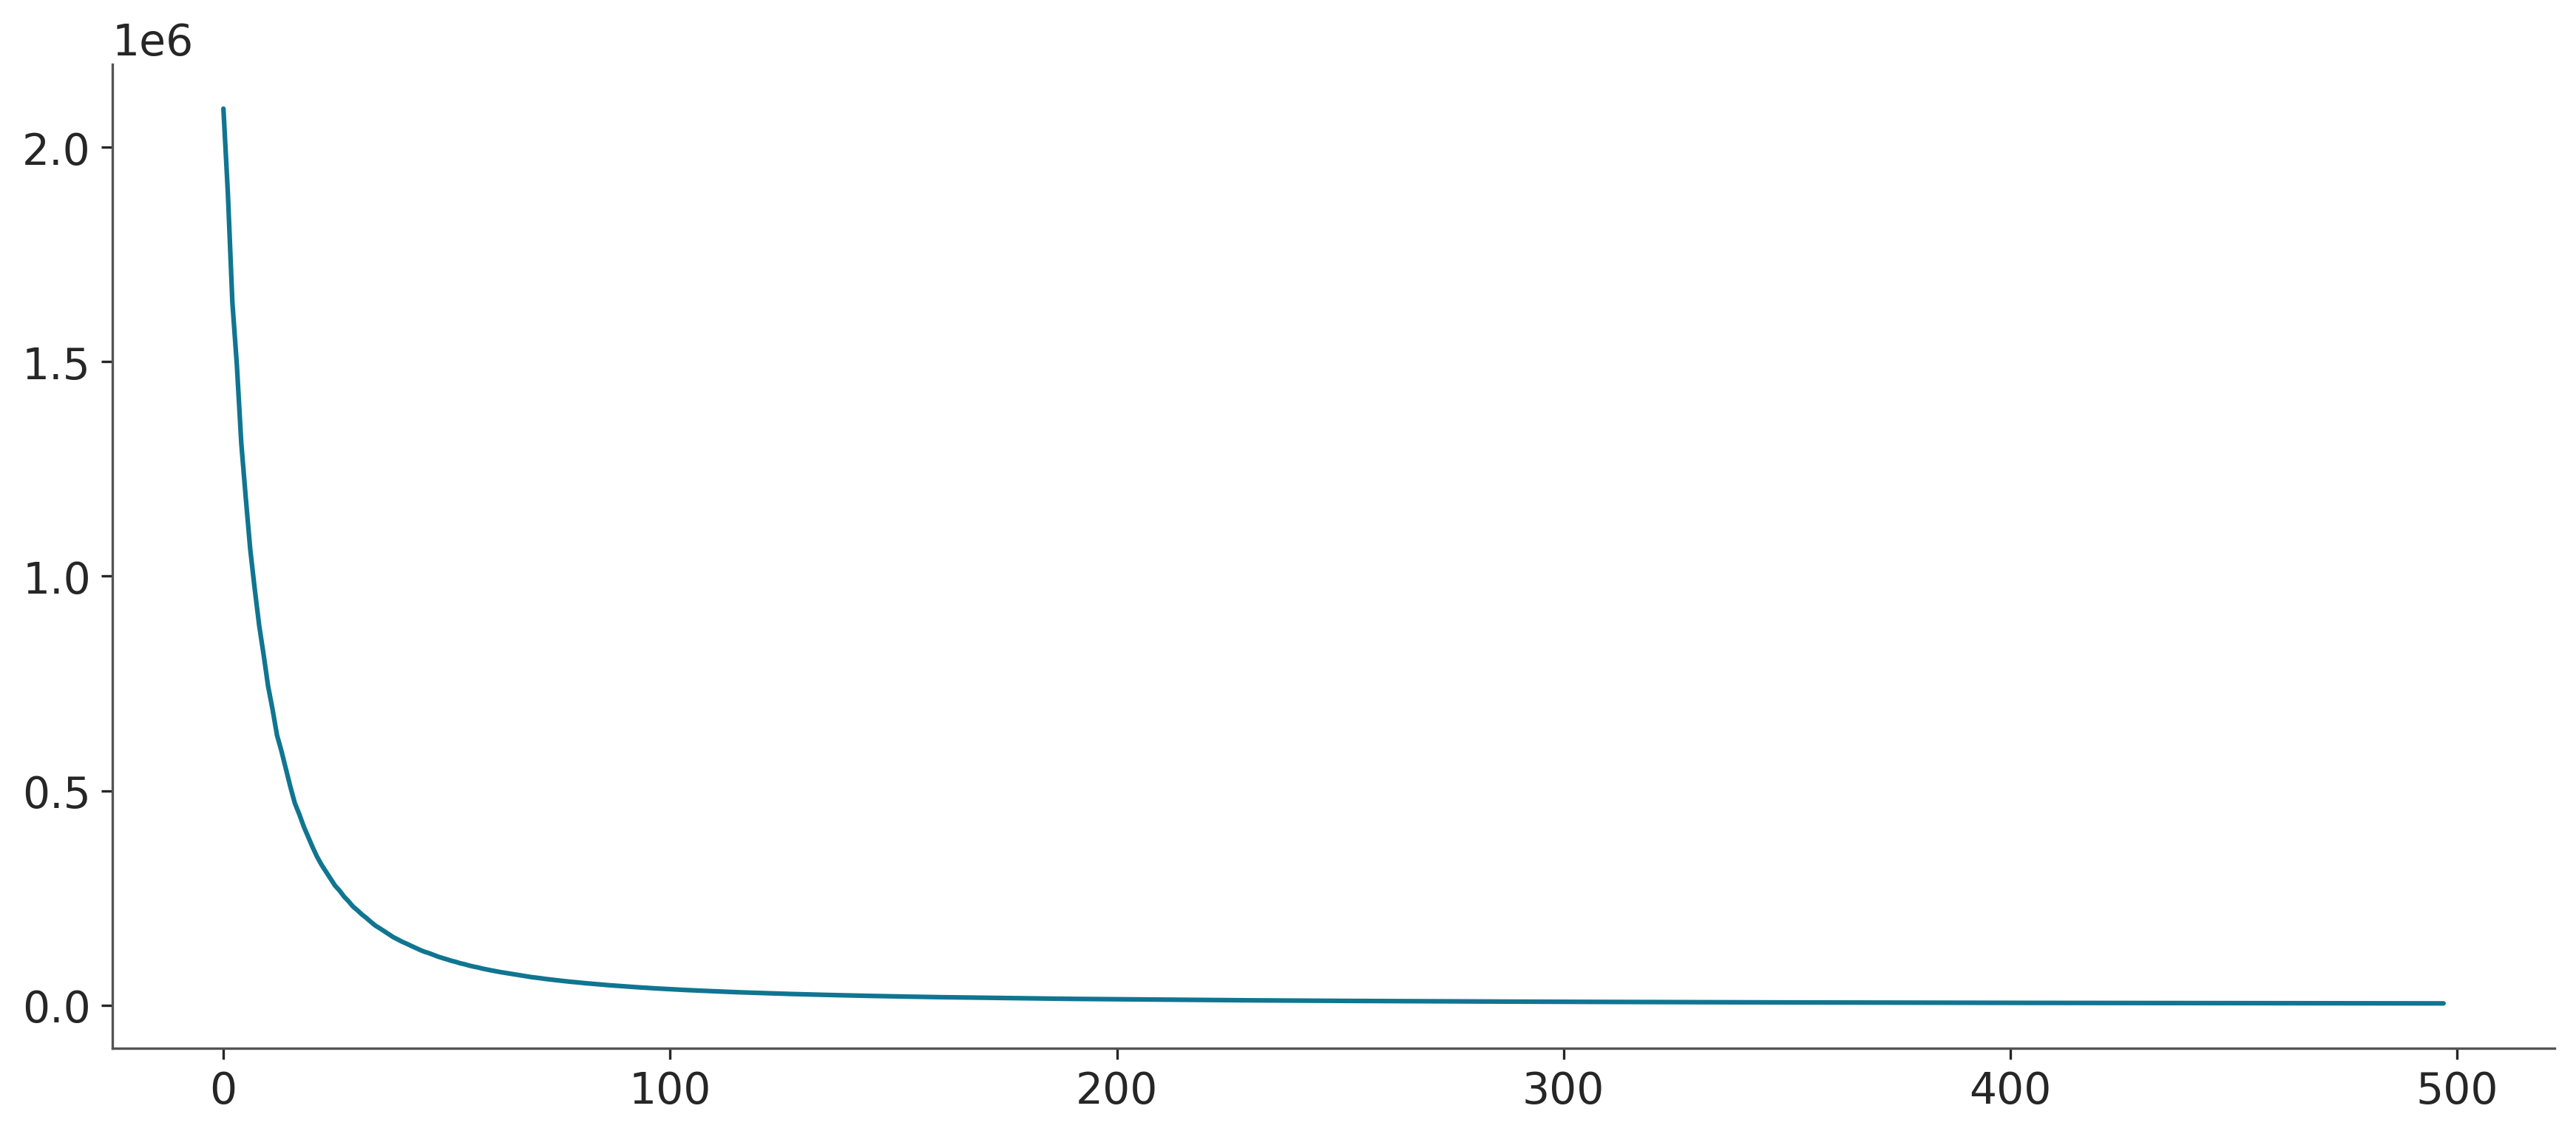

In [11]:
#| echo: false

plt.plot(history.history['loss'][2:])
plt.show()

In [12]:
#| echo: false

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=500, burnin=50):

  def trace_fn(_, pkr):
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
           )

  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn,
      step_size=step_size),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
        inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
  )

  # Sampling from the chain.
  chain_state, sampler_stat = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=hmc,
      trace_fn=trace_fn)
  return chain_state, sampler_stat

The key idea of the [sequential neural likelihood estimation algorithm](http://proceedings.mlr.press/v89/papamakarios19a/papamakarios19a.pdf) is that the density function of the joint distribution evaluated at the observed data $p(X_0 \vert \theta)$ is a neural estimate of the likelihood of the model.


In [ ]:
X_0 = tf.reshape(observed, (200,))

def neural_likelihood(*state):
    return distribution.log_prob(X_0, bijector_kwargs={'conditional_input': state})

It can then be used in an MCMC algorithm to generate samples of an approximation of the posterior distribution.

In [13]:
target_log_prob_fn = lambda *state: neural_likelihood(*state) + ode_prior.log_prob(state)

In [14]:
#| echo: false

step_size = [tf.cast(i, dtype=tf.float32) for i in [.1, .1, .1, .1, .1, .1]]

# bijector to map contrained parameters to real
unconstraining_bijectors = 6 * [tfb.Exp()]

init_state = list(theta[-1].numpy())

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors, burnin=200)

2023-07-12 20:06:51.666230: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


In [15]:
#| echo: false

sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

var_name = ['x0', 'x1', 'a', 'b', 'c', 'd']
posterior = {k:v.numpy()
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

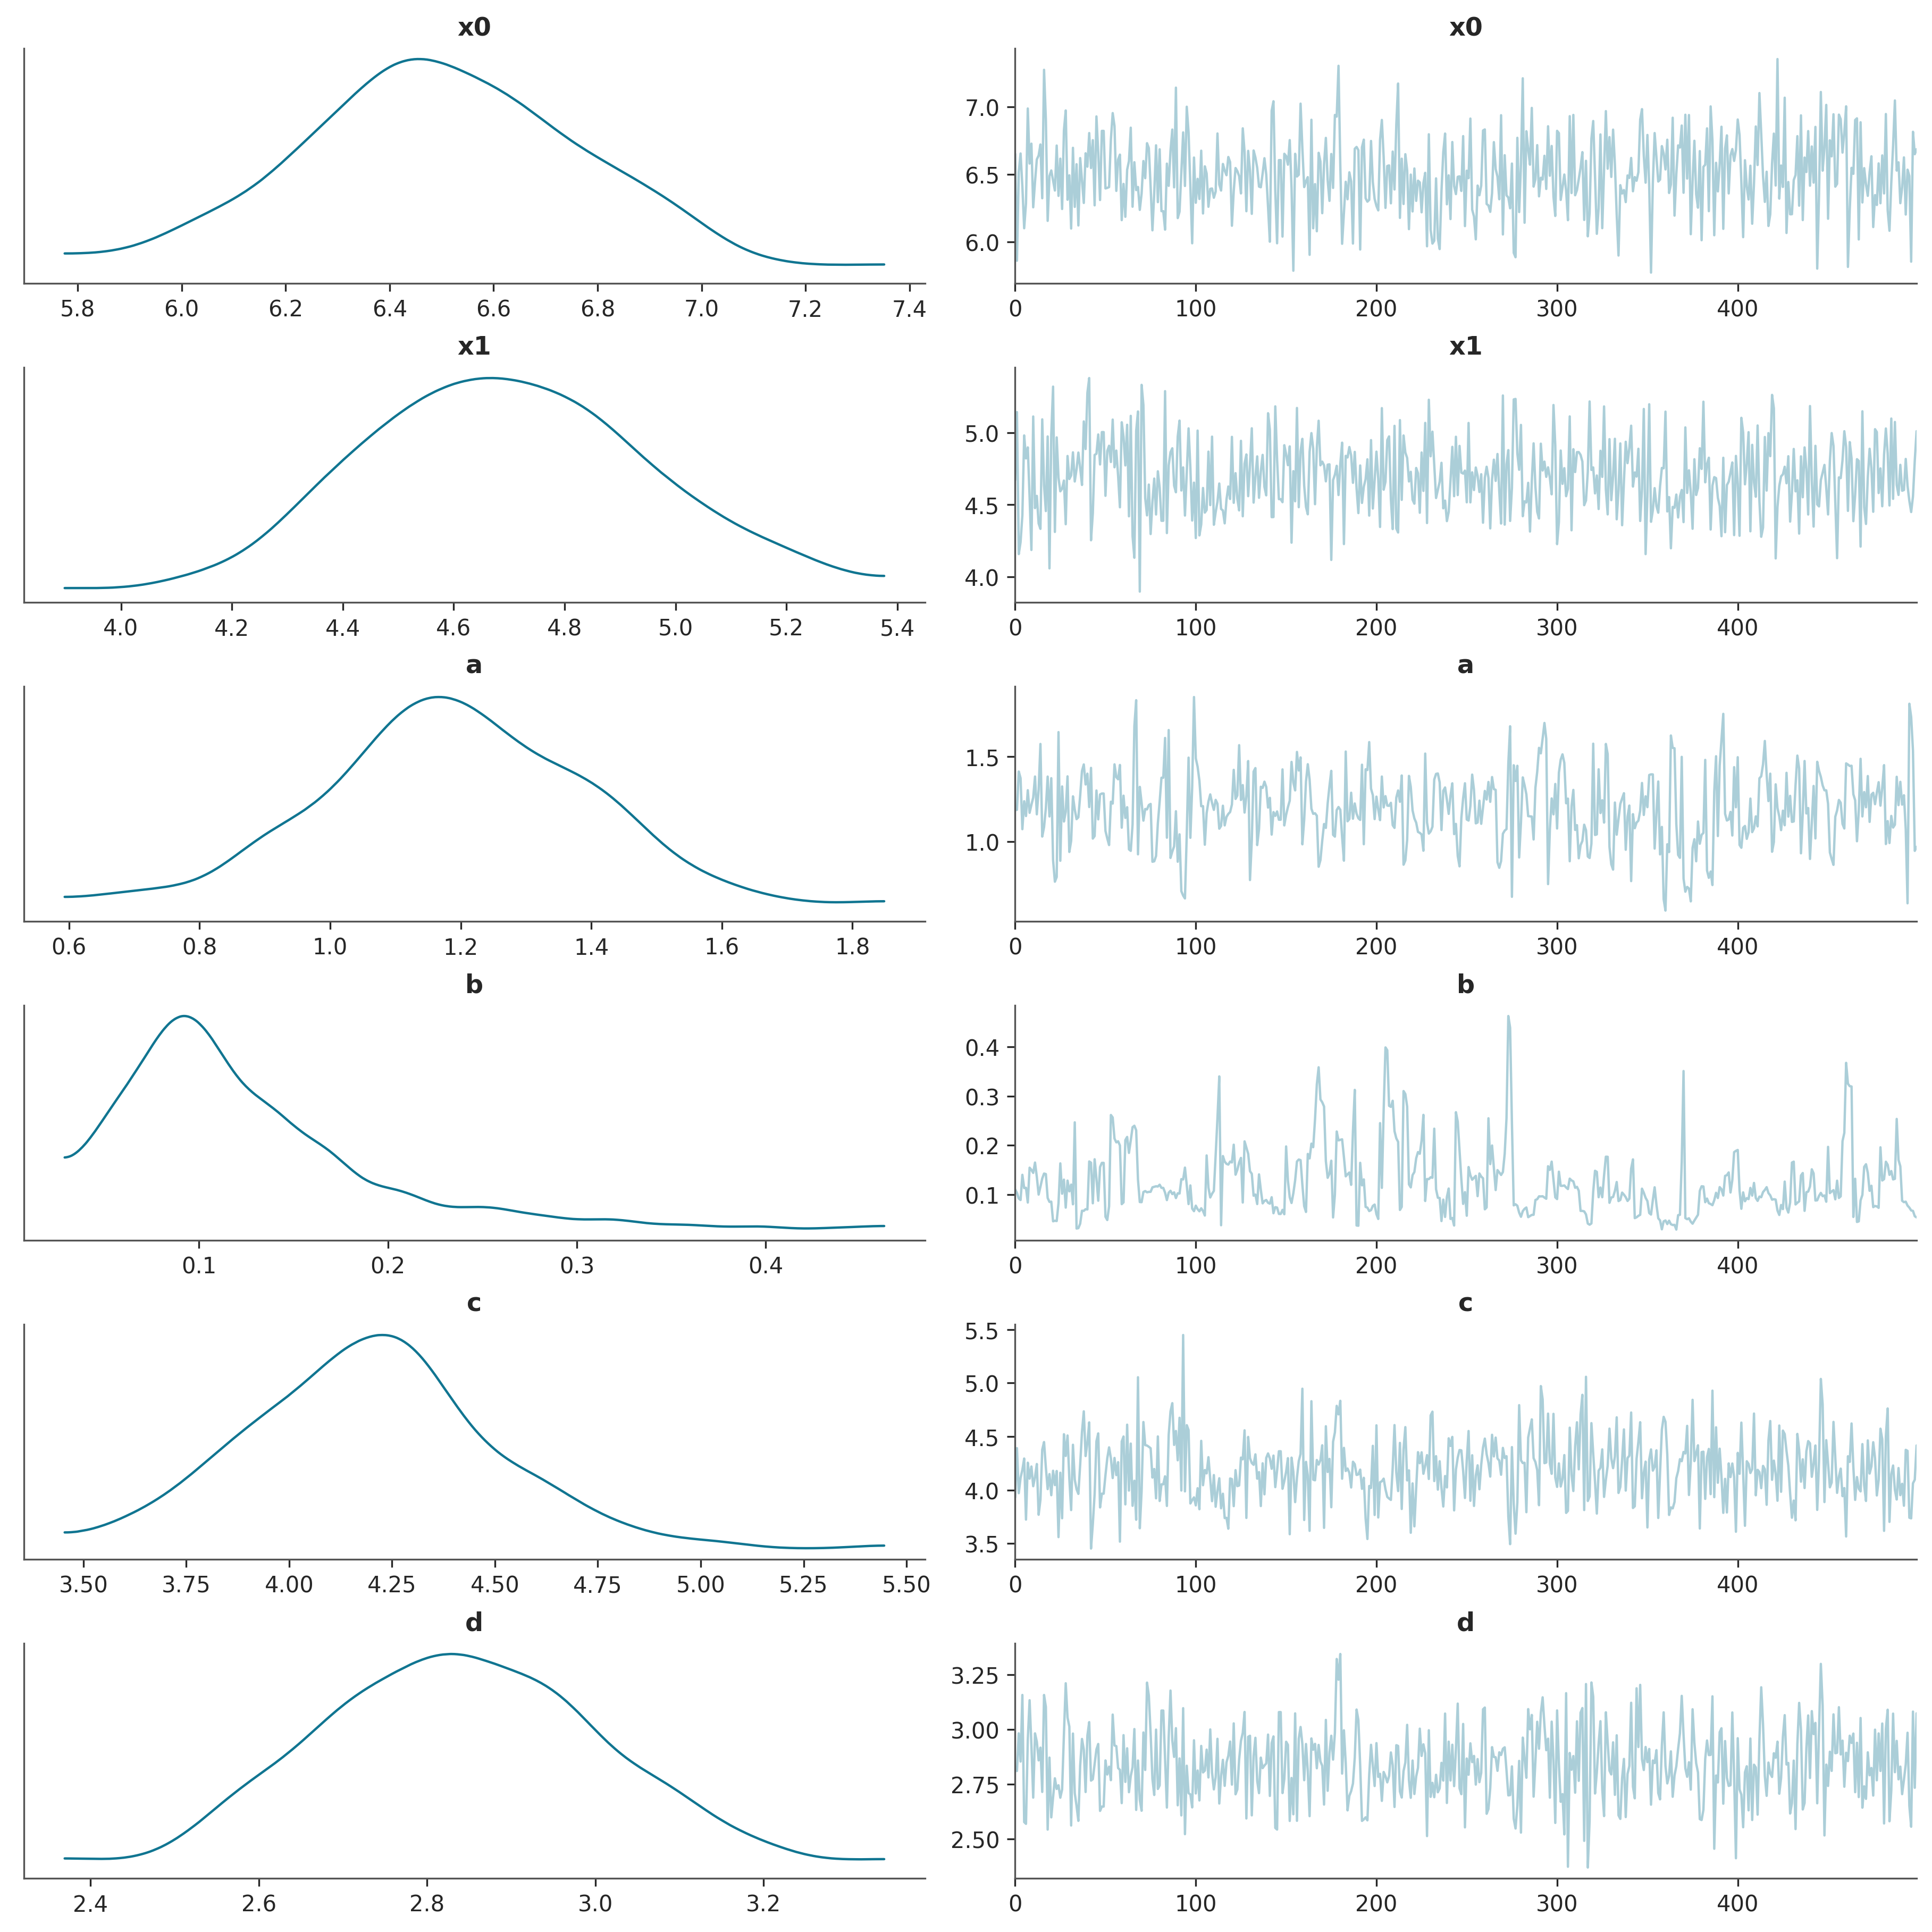

In [16]:
#| echo: false

az.plot_trace(az_trace);

In [29]:
R = 10
N = 100

synthetic_X = X
synthetic_theta = theta

def sample_params(init_theta, size=100):
    init_state = list(init_theta.numpy())
    print('running MC chain')
    samples, _ = run_chain(
        init_state, step_size, target_log_prob_fn, unconstraining_bijectors, num_steps=size, burnin=50)
    return samples

def sample_synthetic_data(param_samples):
    print('running simulation')
    simulation = competition_model(*param_samples)

    print('processing results')

    new_X = tf.reshape(tf.transpose(tf.stack(simulation.states, axis=0)), [-1, 200])
    new_theta = tf.stack(param_samples, axis=1)

    return new_theta, new_X

for i in range(R):
    print(f'Step {i}')
    new_theta, new_X = sample_synthetic_data(sample_params(synthetic_theta[-1], size=N))
    synthetic_theta = tf.concat([synthetic_theta, new_theta], axis=0)
    synthetic_X = tf.concat([synthetic_X, new_X], axis=0)

    history = model.fit(x=[synthetic_X, synthetic_theta],
                    y=np.zeros((synthetic_X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=200,
                    steps_per_epoch=synthetic_X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)



Step 0
running MC chain
running simulation
processing results
Step 1
running MC chain
running simulation
processing results
Step 2
running MC chain
running simulation
processing results
Step 3
running MC chain
running simulation
processing results
Step 4
running MC chain
running simulation
processing results
Step 5
running MC chain
running simulation
processing results
Step 6
running MC chain
running simulation
processing results
Step 7
running MC chain
running simulation
processing results
Step 8
running MC chain
running simulation
processing results
Step 9
running MC chain
running simulation
processing results


In [30]:
init_state = list(synthetic_theta[-1].numpy())

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors, burnin=200, num_steps=1000)

In [31]:
#| echo: false

sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

var_name = ['x0', 'x1', 'a', 'b', 'c', 'd']
posterior = {k:v.numpy()
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

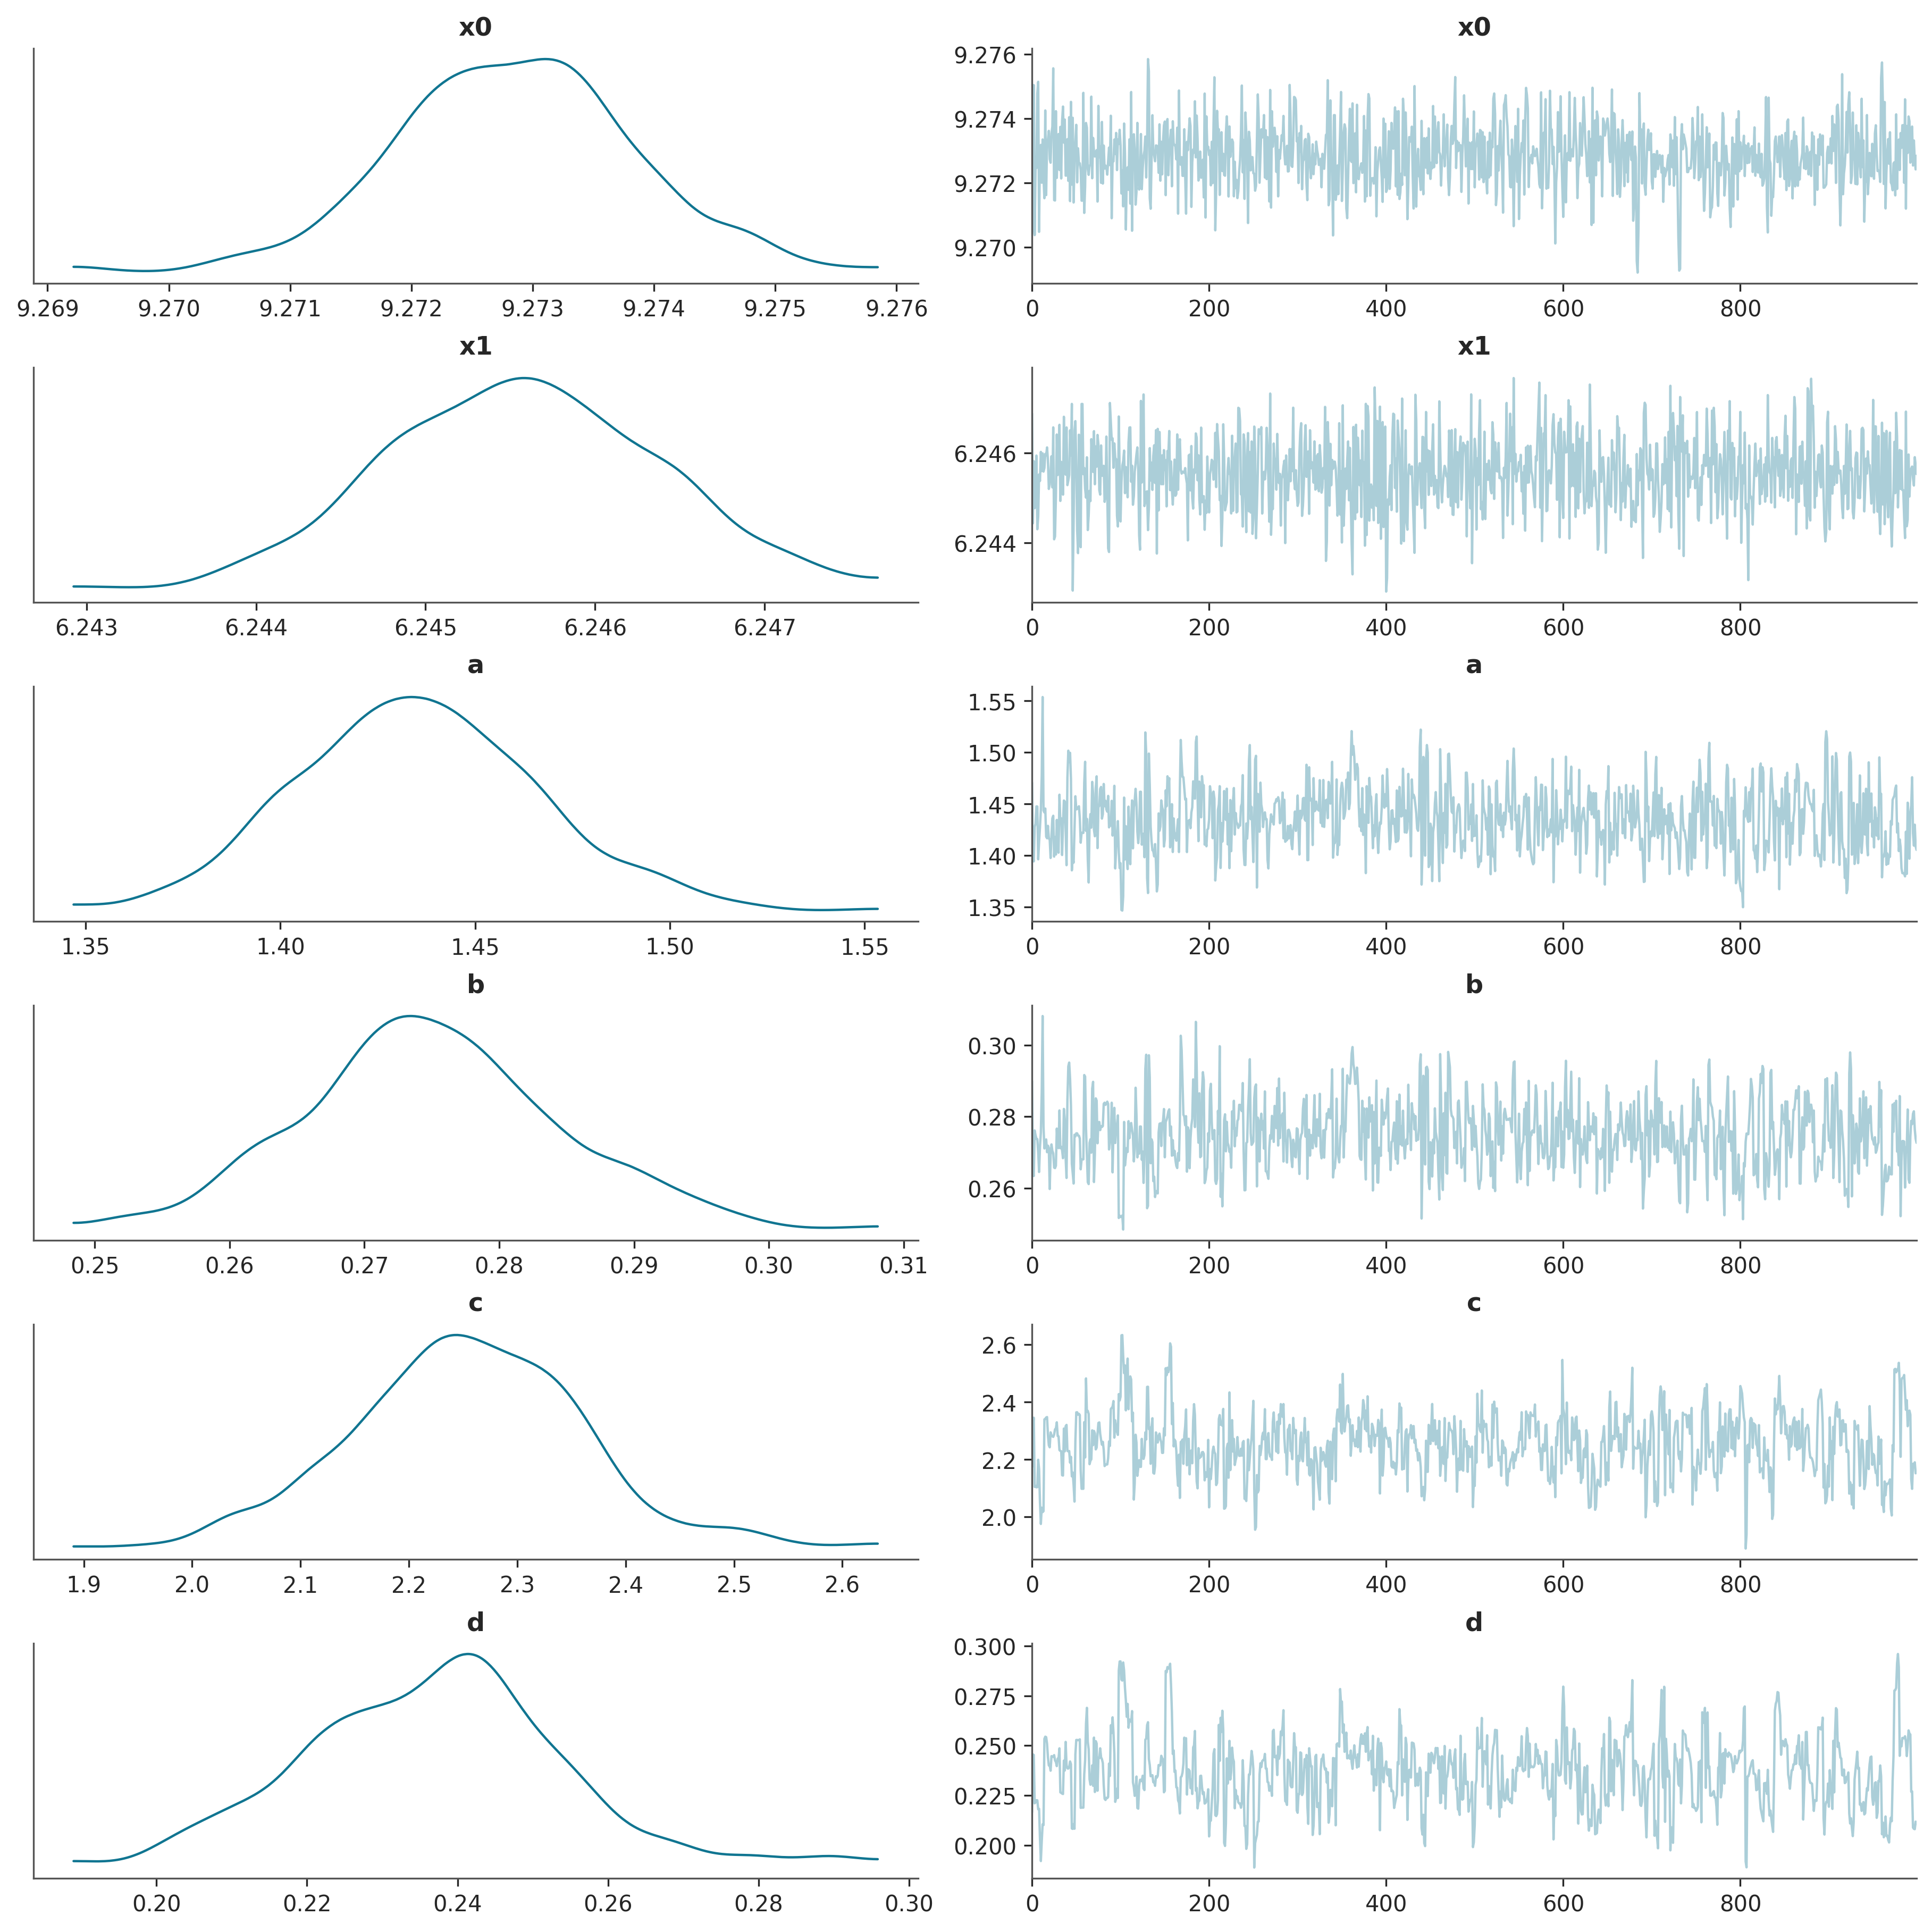

In [32]:
az.plot_trace(az_trace)
plt.show()

In [33]:
#| echo: false

posterior_predictive = tf.stack(competition_model(*samples).states)

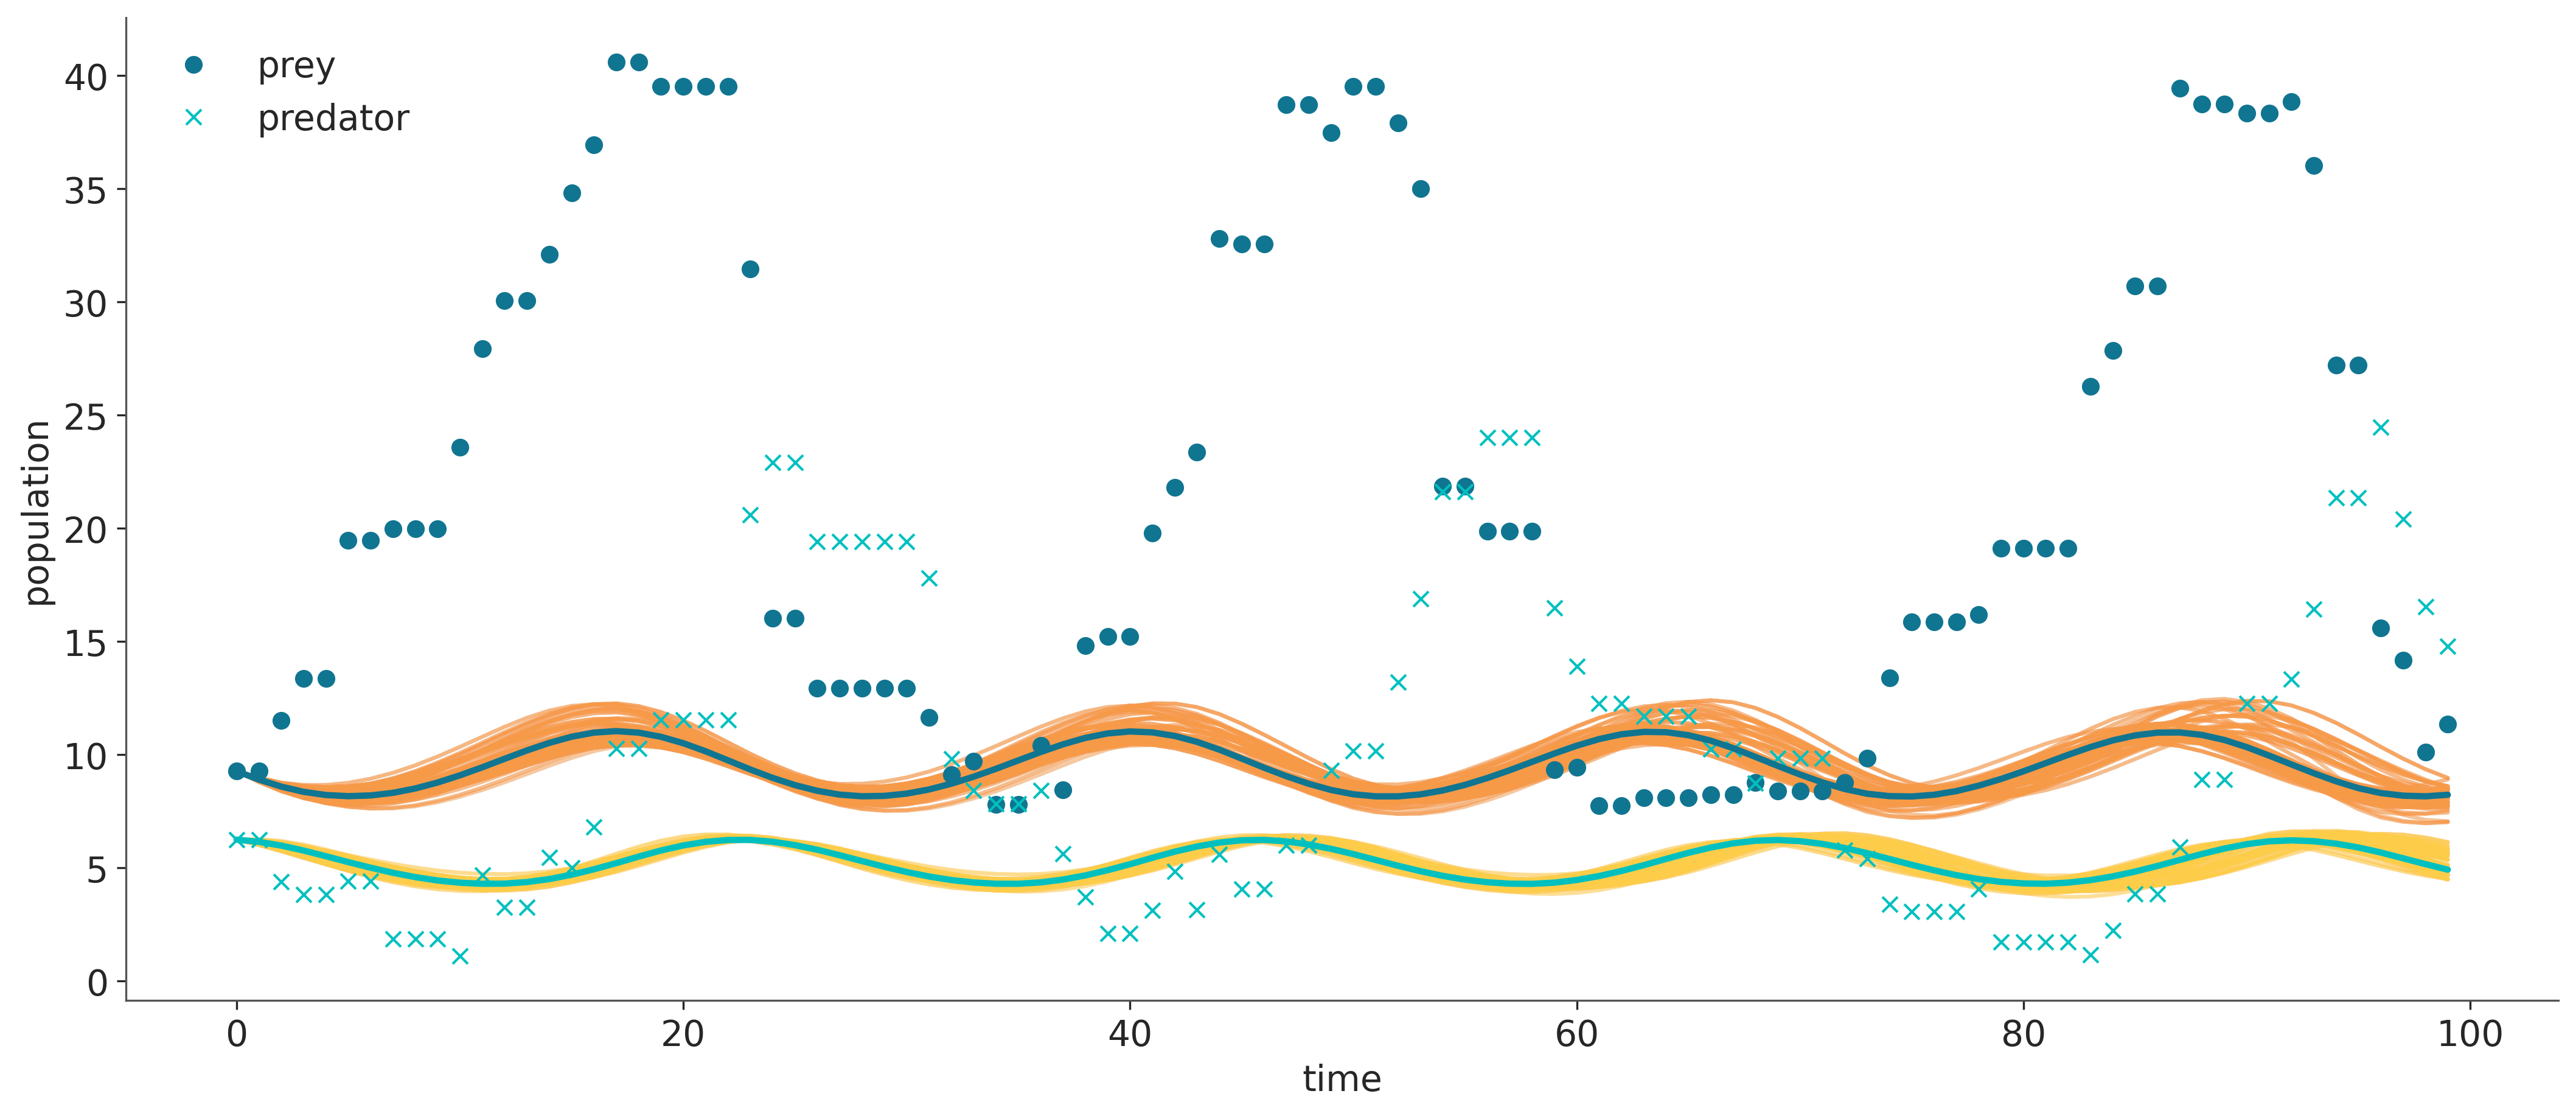

In [34]:
#| echo: false

_, ax = plt.subplots(figsize=(14,6))
ax.plot(observed[:, 0], 'o', label='prey', c='C0')
ax.plot(observed[:, 1], 'x', label='predator', c='C1')
ax.plot(tf.transpose(tf.reduce_mean(posterior_predictive, axis=-1)), linewidth=2.5)
for i in np.random.randint(0, 50, 1000):
    ax.plot(posterior_predictive[0, :, i], alpha=0.05, c='C2', zorder=0)
    ax.plot(posterior_predictive[1, :, i], alpha=0.05, c='C3', zorder=0)
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend();




positive parameters to avoid integration problems